In [1]:
# Imports
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import warnings
import sys
import os

np.random.seed(42)

In [2]:
# ignore Warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings('ignore')
    os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
def transform_numeric_columns(df, exclude_cols):
    # Create a copy of the DataFrame to avoid modifying the original
    df_transformed = df.copy()
    
    # Select only numeric columns
    num_cols = df_transformed.select_dtypes(include=['int64', 'float64']).columns
    
    # Exclude specified columns
    cols_to_transform = [col for col in num_cols if col not in exclude_cols]
    
    # Apply the PowerTransformer with the yeo-johnson method
    pt = PowerTransformer(method='yeo-johnson')
    df_transformed[cols_to_transform] = pt.fit_transform(df_transformed[cols_to_transform])
    
    return df_transformed


In [4]:
def sbgrp_performance(df, groupby_col, label_map):
    """
    This function takes in a DataFrame, a column name and a label map and creates a confusion matrix for each unique value in the specified column.

    :param df: DataFrame containing true labels, predicted labels and groupby column
    :type df: pandas.DataFrame
    :param groupby_col: Column name to group data by
    :type groupby_col: str
    :param label_map: Dictionary that maps integer labels to string labels
    :type label_map: dict
    """
    
    # Get a list of unique values in the specified column
    groups = df[groupby_col].unique()

    # Sort the groups in ascending order
    groups.sort()

    # Create a figure with subplots for each group
    fig, axs = plt.subplots(1, len(groups), figsize=(5 * len(groups), 5))

    # Loop through each group
    for i, group in enumerate(groups):
        # Filter the DataFrame to only include data for the current group
        df_group = df[df[groupby_col] == group]

        # Get the true and predicted labels for the current group
        y_true = df_group['Movement']
        y_pred = df_group['prediction_label']

        # Calculate the confusion matrix for the current group
        cm = confusion_matrix(y_true, y_pred)

        # Convert the confusion matrix to a DataFrame with appropriate column and row labels
        columns = [label_map[i] for i in range(len(label_map))]
        df_cm = pd.DataFrame(cm, columns=columns, index=columns)

        # Create a seaborn heatmap to visualize the confusion matrix on the corresponding subplot
        ax = sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap='Greens', cbar=False, ax=axs[i]) # font size

        # Calculate performance metrics for the current group
        auc = roc_auc_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Update the layout of the heatmap to include a title and axis labels
        ax.set_title(f'Confusion Matrix for {groupby_col} {group}\nAUC: {auc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    # Show the figure with all subplots
    plt.show()

### Data Import and Preparation

In [5]:
df=pd.read_csv("../Data/FinalDF/FinalDF.csv", encoding="utf-8", sep="~")

In [6]:
# Define the columns you want to exclude
cols_to_exclude = ['Company', 'year', "day", "month", 'Is Trading Day', "day_of_week","day_of_year","quarter", 'cos_day','sin_day']

# Transform the numeric featuresof the dataset
df = transform_numeric_columns(df, cols_to_exclude)

In [7]:
# convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [8]:
# Map companies and Movement an create inversions for future refference
company_map={'AMAZON': 0, 'APPLE': 1, 'TESLA': 2, 'MICROSOFT':3}
movement_map={"Up":1, "Down":0}

inverted_company_map={v: k for k, v in company_map.items()}
inverted_movement_map={v: k for k, v in movement_map.items()}

df['Company']=df['Company'].map(company_map)

df['Movement']=df['Movement'].map(movement_map)
df['PWD Movement']=df['PWD Movement'].map(movement_map)

In [9]:
# Create a TimeSeriesSplit object with the desired number of splits
val_size=0.3

train_data, val_data = train_test_split(df, test_size=val_size)

In [10]:
target="Movement"

# Drop Close and Movement columns to avoid data leakage
class_df_train=train_data.drop(columns=["Date", 'Close', "Adj Close", "Price Change"])

class_df_val=val_data.drop(columns=["Date", 'Close', "Adj Close", "Price Change"])

## Classification

In [11]:
from pycaret.classification import *

In [12]:
# Create the Classification Experiment Enviroment
setup=setup(class_df_train, target=target, session_id = 124, n_jobs=-1, fold=20, use_gpu=True, feature_selection=True, 
            keep_features=['Company', 'year', "day", "month", "day_of_week", "day_of_year","quarter", 'cos_day','sin_day'])

In [13]:
# Find the top model in terms of auc
top_models = compare_models(n_select = 3, sort = 'auc', include=["knn", "svm", "rf", "et", "xgboost", "lightgbm"])

In [14]:
# Tune top 3 models
tuned_top3 = [tune_model(i, optimize = 'auc', folds=20 early_stopping=True) for i in top3]

Fitting 30 folds for each of 10 candidates, totalling 300 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [15]:
# Ensemble Top Model
#bagged_model=ensemble_model(top_models[0], method = 'Bagging', choose_better=True, optimize='auc')

In [16]:
# Blend top 3 models
#blender = blend_models(top_models, choose_better=True, optimize='auc')

In [17]:
# Find the best model of the classification experiment
best_model=automl(optimize = 'auc')

In [18]:
# Retrain the model with also the test data
final_model=finalize_model(best_model)

# Copy the final Training Results
trainning_results=pull()

In [19]:
# Print the final Training Results
trainning_results.iloc[-2]

Accuracy    0.7008
AUC         0.8155
Recall      0.9388
Prec.       0.6538
F1          0.7703
Kappa       0.3796
MCC         0.4341
Name: Mean, dtype: float64

In [20]:
# Get model parameters
parameters=plot_model(final_model, plot='parameter')

,Parameters
objective,binary:logistic
use_label_encoder,None
base_score,None
booster,gbtree
callbacks,None
colsample_bylevel,None
colsample_bynode,None
colsample_bytree,None
early_stopping_rounds,None
enable_categorical,False


In [21]:
# Use the model to predict on the validation set
predictions = predict_model(final_model, data=class_df_val)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7466,0.8394,0.7815,0.7635,0.7724,0.4866,0.4868


In [22]:
#evaluate_model(final_model)
validaton_results = pull()
validaton_results

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7466,0.8394,0.7815,0.7635,0.7724,0.4866,0.4868


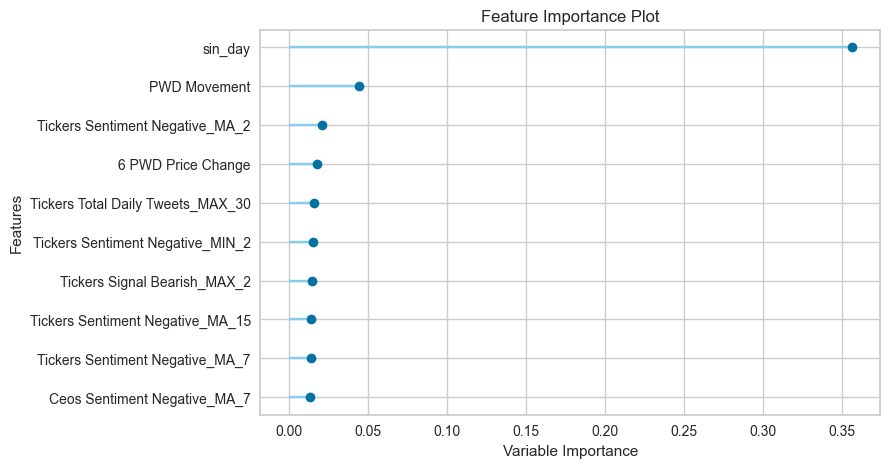

In [23]:
# Plot Feature Importance
plot_model(final_model, plot='feature')

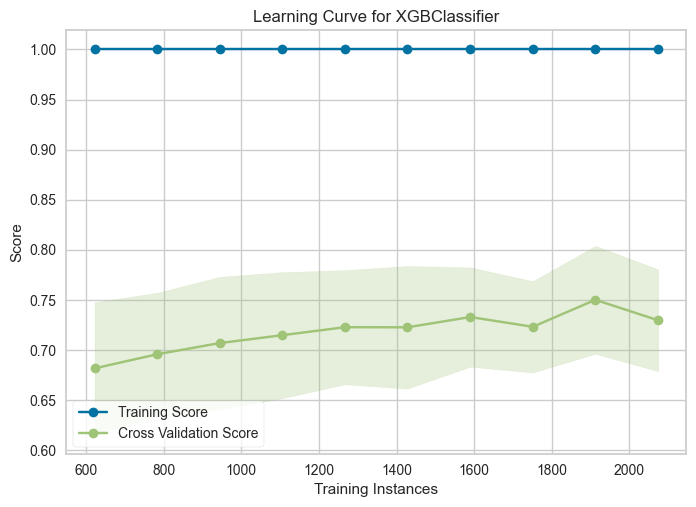

In [26]:
# Plot Precision Recall Curve
plot_model(final_model, plot='learning')

In [27]:
pipeline = final_model

In [28]:
predictions=predictions[predictions['Is Trading Day'] == 1]

In [29]:
# Inverse Mapping for Movement and Company collumns for Confusion Matrices
predictions['Company']=predictions['Company'].map(inverted_company_map)

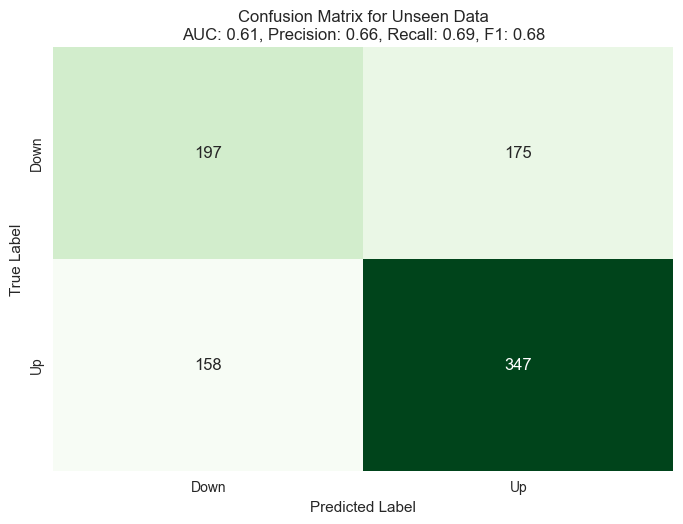

In [30]:
# Plot Confussion Matrix for Unseen Data
# Get the true and predicted labels for the current group
y_true = predictions['Movement']
y_pred = predictions['prediction_label']

# Calculate the confusion matrix for the current group
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm)

# Convert the confusion matrix to a DataFrame with appropriate column and row labels
columns = [inverted_movement_map[i] for i in range(len(inverted_movement_map))]
df_cm = pd.DataFrame(cm, columns=columns, index=columns)

# Calculate performance metrics for the current group
auc = roc_auc_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a seaborn heatmap to visualize the confusion matrix
ax = sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap='Greens', cbar=False)

# Update the layout of the heatmap to include a title and axis labels
ax.set_title(f'Confusion Matrix for Unseen Data\nAUC: {auc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the heatmap
plt.show()

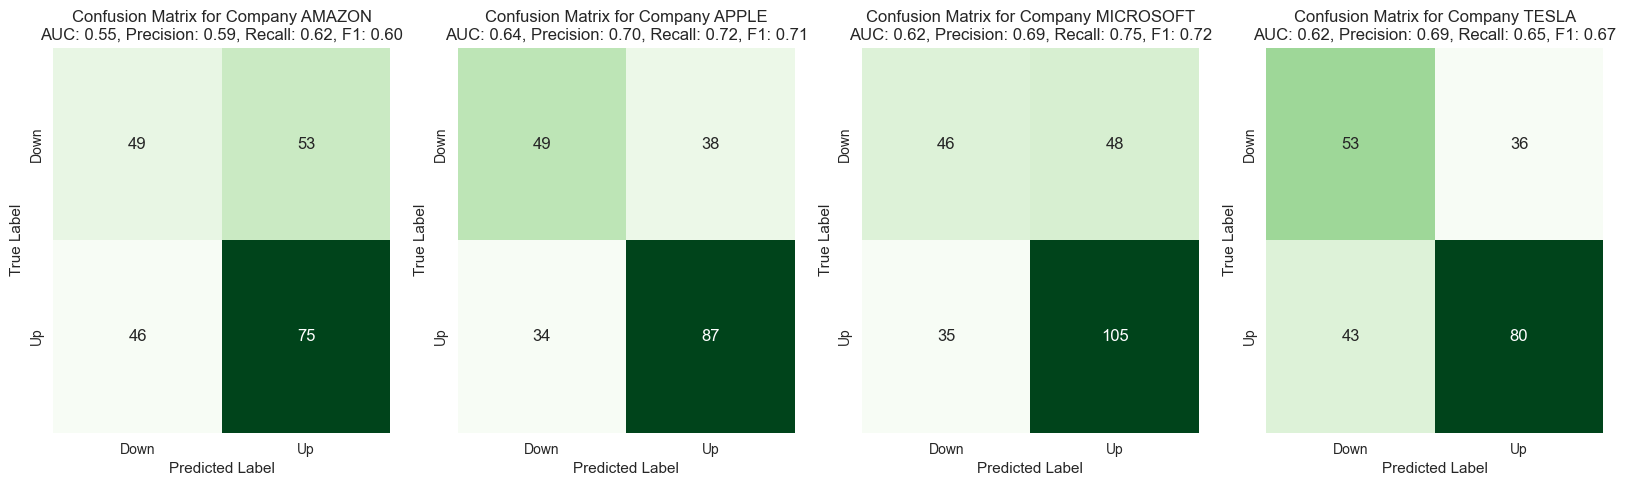

In [31]:
sbgrp_performance(predictions, 'Company', inverted_movement_map)

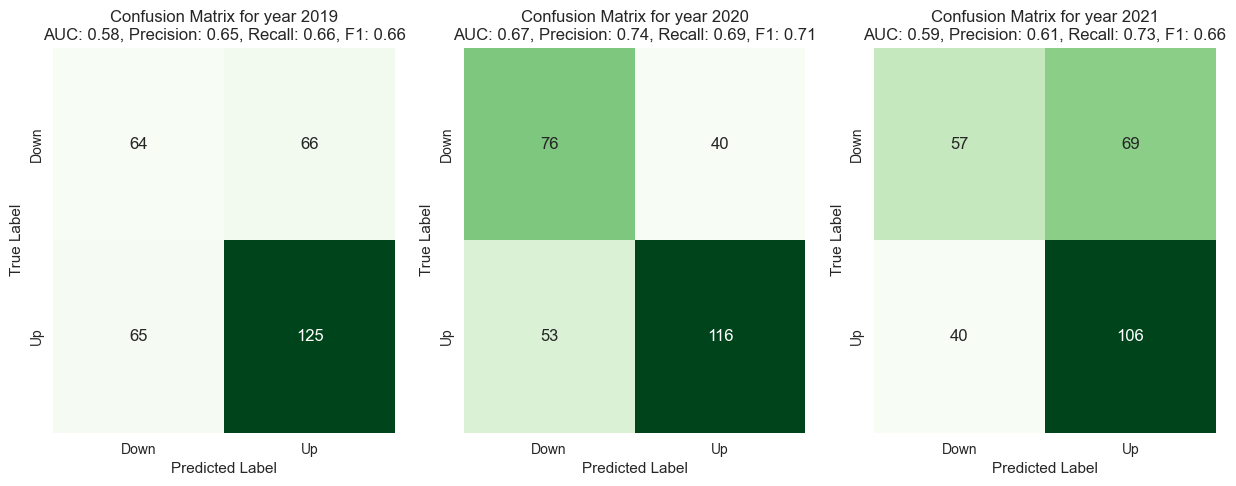

In [32]:
sbgrp_performance(predictions, 'year', inverted_movement_map)

In [ ]:
#dashboard(final_model[-1])